# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-95-media-campaign-cost-prediction/304/overview/about

# Methodology:
1. Con

### Import all libraries required

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from sklearn.decomposition import PCA
import lightgbm as lgb

### Declare the path

In [2]:
train_path = '/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.3,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
0,2.65,5.0,4.0,1.0,4.0,6.89,0.0,1.0,5.0,33858.0,1.0,0.0,1.0,1.0,1.0


# dtype conversions
store_sales(in millions) - float16
unit_sales(in millions) - uint8
total_children - uint8
num_children_at_home - uint8
avg_cars_at home(approx).1 - uint8
gross_weight - float16
recyclable_package - uint8
low_fat - uint8
units_per_case - uint8
store_sqft - uint16
coffee_bar - uint8
video_store - uint8
salad_bar - uint8
prepared_food - uint8
florist - uint8
cost - float16

In [4]:
train_df.columns

Index(['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',
       'cost'],
      dtype='object')

In [5]:
uint8_cols = ['unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 
       'recyclable_package', 'low_fat', 'units_per_case', 
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',]
uint16_cols = ['store_sqft',]
float16_cols = ['store_sales(in millions)', 'gross_weight']
target_col = ['cost']

In [6]:
for i in train_df.columns:
    if i in uint8_cols:
        train_df[i] = train_df[i].astype('uint8')
        test_df[i] = test_df[i].astype('uint8')
    elif i in uint16_cols:
        train_df[i] = train_df[i].astype('uint16')
        test_df[i] = test_df[i].astype('uint16')
    elif i in float16_cols:
        train_df[i] = train_df[i].astype('float16')
        test_df[i] = test_df[i].astype('float16')        

In [7]:
train_df.cost = train_df.cost.astype('float16')

# Memory usage reduced from 6 MB to 1 MB

In [8]:
train_df.isnull().sum()

store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
cost                          0
dtype: int64

In [9]:
test_df.isnull().sum()

store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
dtype: int64

# There are no null values, no missing data

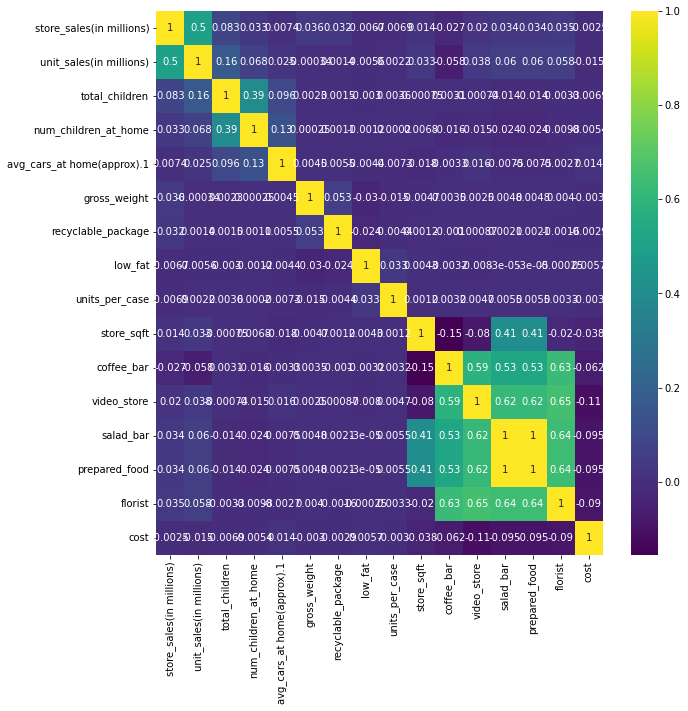

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), annot=True, cmap='viridis')
plt.show()

# The features salad bar and prepared food are highly correlated, let's drop the second one

In [11]:
train_df.drop('prepared_food', axis=1, inplace=True)
test_df.drop('prepared_food', axis=1, inplace=True)

# Drop duplicate rows

In [12]:
print(train_df.shape)
train_df.drop_duplicates(inplace=True)
print(train_df.shape)

(51363, 15)
(51328, 15)


In [13]:
# Ratios
train_df['store_sale_by_weight'] = train_df['store_sales(in millions)']/train_df['gross_weight']
train_df['unit_sale_by_weight'] = train_df['unit_sales(in millions)']/train_df['gross_weight']
train_df['store_sale_by_case'] = train_df['store_sales(in millions)']/train_df['units_per_case']
train_df['unit_sale_by_case'] = train_df['unit_sales(in millions)']/train_df['units_per_case']
train_df['store_sale_by_sqft'] = train_df['store_sales(in millions)']/train_df['store_sqft']
train_df['unit_sale_by_sqft'] = train_df['unit_sales(in millions)']/train_df['store_sqft']

test_df['store_sale_by_weight'] = test_df['store_sales(in millions)']/test_df['gross_weight']
test_df['unit_sale_by_weight'] = test_df['unit_sales(in millions)']/test_df['gross_weight']
test_df['store_sale_by_case'] = test_df['store_sales(in millions)']/test_df['units_per_case']
test_df['unit_sale_by_case'] = test_df['unit_sales(in millions)']/test_df['units_per_case']
test_df['store_sale_by_sqft'] = test_df['store_sales(in millions)']/test_df['store_sqft']
test_df['unit_sale_by_sqft'] = test_df['unit_sales(in millions)']/test_df['store_sqft']

# Function to cap Skew

In [121]:
def skew_cap(df):
    percentile25 = df.quantile(0.25)
    percentile75 = df.quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 3 * iqr
    lower_limit = percentile25 - 3 * iqr
    new_df = df.copy()
    new_df = np.where(new_df > upper_limit, upper_limit, np.where(new_df < lower_limit, lower_limit, new_df))
    return new_df

In [ ]:
skew_cols = 

# Separate dependent and independent features

In [14]:
train_X = train_df.drop(['cost'], axis=1).copy()
train_y = train_df.cost.copy()
final_X = test_df.copy()

# Visualize the data

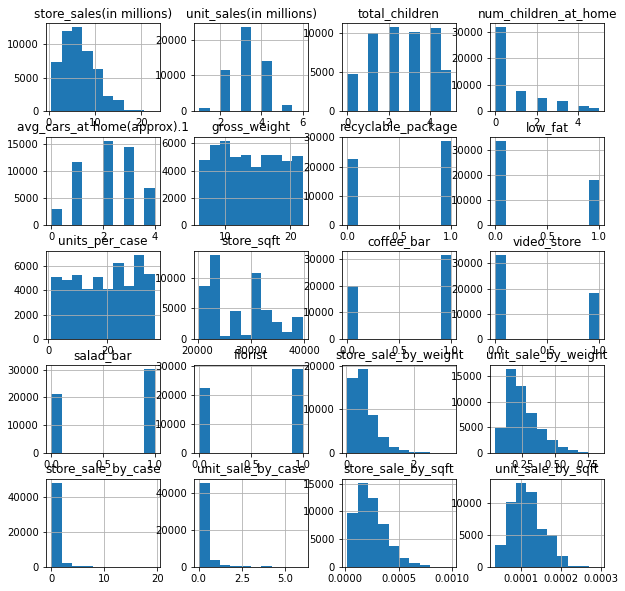

In [15]:
train_X.hist(figsize=(10,10))
plt.show()

# Split the data

In [77]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

In [113]:
# Define the models for regression

models = {
'LIN': LinearRegression(),
'RID': Ridge(),
'LAS': Lasso(),
# 'RFR': RandomForestRegressor(n_jobs=4),
'ADA': AdaBoostRegressor(),
# 'DCT': DecisionTreeRegressor(),
# 'XGB': XGBRegressor(n_jobs=4)
}

In [114]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    print(f"{name}: {-1*(cv_results.mean()):.1f}")

LIN: 29.6
RID: 29.7


/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+07, tolerance: 2.776e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+07, tolerance: 2.766e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LAS: 29.5
ADA: 29.4


# Let's use polynomial features

In [16]:
poly = PolynomialFeatures(degree=3)

In [17]:
train_X_poly = poly.fit_transform(train_X)
train_X_poly

array([[1.00000000e+00, 2.67968750e+00, 2.00000000e+00, ...,
        5.02013552e-13, 3.74680669e-13, 2.79645047e-13],
       [1.00000000e+00, 5.73046875e+00, 3.00000000e+00, ...,
        1.17434193e-11, 6.14788409e-12, 3.21852416e-12],
       [1.00000000e+00, 2.61914062e+00, 2.00000000e+00, ...,
        1.63546255e-12, 1.24885438e-12, 9.53636787e-13],
       ...,
       [1.00000000e+00, 1.11875000e+01, 3.00000000e+00, ...,
        1.28547042e-11, 3.44707161e-12, 9.24354426e-13],
       [1.00000000e+00, 3.77929688e+00, 3.00000000e+00, ...,
        3.26075137e-12, 2.58837937e-12, 2.05465152e-12],
       [1.00000000e+00, 2.91015625e+00, 3.00000000e+00, ...,
        4.06175428e-13, 4.18715063e-13, 4.31641828e-13]])

In [18]:
train_X_poly.shape

(51328, 1771)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(train_X_poly, train_y, test_size=0.25, random_state=42)

In [86]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    print(f"{name}: {-1*(cv_results.mean()):.1f}")

LIN: 29.7


/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.94815e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.93785e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.93253e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.92438e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True

RID: 29.5


/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+07, tolerance: 2.776e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+07, tolerance: 2.766e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LAS: 29.6


/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+07, tolerance: 2.767e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


RFR: 29.8
ADA: 29.3
DCT: 41.0
XGB: 29.9


In [112]:
model_las = Lasso(alpha=0.0001,
    fit_intercept=True,
    max_iter=2000,
    tol=0.00001,
    selection='cyclic',) 
model_las.fit(X_train, y_train)
preds_las = model_las.predict(X_test)
print(f'RMSE: {np.sqrt(mse(y_test, preds_las)):0.2f}')

RMSE: 29.55


/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+07, tolerance: 3.464e+02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [35]:
pca = PCA(n_components=30)
train_X_poly_pca = pca.fit_transform(train_X_poly)

In [36]:
train_X_poly_pca.shape

(51328, 30)

In [285]:
pca.explained_variance_

array([           inf, 8.89485211e+28, 1.82818107e+28, 1.02240096e+28,
       2.36477903e+27, 1.01821696e+27, 9.15662434e+26, 4.62789739e+26,
       3.77574599e+26, 2.06267139e+26, 1.90397442e+26, 9.89670125e+25,
       6.75034204e+25, 1.37110763e+25, 8.95050722e+23, 9.79910771e+21,
       1.40013999e+21, 1.40013999e+21, 1.40013999e+21, 1.40013999e+21,
       1.40013999e+21, 1.40013999e+21, 1.40013999e+21, 1.40013999e+21,
       1.40013999e+21, 1.40013999e+21, 1.40013999e+21, 1.40013999e+21,
       1.40013999e+21, 1.40013999e+21], dtype=float32)

In [286]:
pca.explained_variance_ratio_

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.], dtype=float32)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_X_poly_pca, train_y, test_size=0.1, random_state=42)
model_ada = AdaBoostRegressor( n_estimators=150, learning_rate=0.1, loss='linear',)
model_ada.fit(X_train, y_train)
preds_ada = model_ada.predict(X_test)
print(f'RMSE: {np.sqrt(mse(y_test, preds_ada)):0.2f}')

RMSE: 29.38


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X_poly_pca, train_y, test_size=0.1)#, random_state=42

In [42]:
model_rfr = RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=4, random_state=1,)
model_rfr.fit(X_train, y_train)
preds_rfr = model_rfr.predict(X_test)
print(f'RMSE: {np.sqrt(mse(y_test, preds_rfr)):0.2f}')

RMSE: 29.02


In [19]:
final_X_poly = poly.fit_transform(final_X.iloc[:,:-1])

In [20]:
final_X_poly.shape

(9065, 1771)

In [43]:
final_X_poly_pca = pca.transform(final_X_poly)

In [44]:
preds_final = model_rfr.predict(final_X_poly_pca)

In [45]:
final_X['cost'] = preds_final

In [46]:
final_X['cost'].to_csv('/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/submission/sub11.csv', index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.1)#, random_state=42

In [188]:
model_rfr = RandomForestRegressor(n_estimators=150, max_depth=10, max_features='auto', n_jobs=4, random_state=1,)
model_rfr.fit(X_train, y_train)
preds_rfr = model_rfr.predict(X_test)
print(f'RMSE: {np.sqrt(mse(y_test, preds_rfr)):0.2f}')

RMSE: 28.79


In [189]:
final_X['cost'] = model_rfr.predict(final_X.iloc[:,:-1])

In [190]:
final_X['cost'].to_csv('/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/submission/sub3.csv', index=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_X_poly_pca, train_y, test_size=0.1, random_state=42)#

In [47]:
model_xgb = XGBRegressor(n_jobs=4, n_estimators=100, max_depth=6, learning_rate=0.09, random_state=1)
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)
print(f'RMSE: {np.sqrt(mse(y_test, preds_xgb)):0.2f}')

KeyboardInterrupt: 

In [227]:
final_X['cost'] = model_xgb.predict(final_X_poly_pca)
final_X['cost'].to_csv('/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/submission/sub4.csv', index=False)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_X_poly, train_y, test_size=0.1, random_state=42)#

In [53]:
hyper_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 
                'learning_rate': 0.1, 'n_estimators':2000,'verbose': -1, 'metric':['l2'],
                'random_state':1, 'max_depth': -1, 'colsample_bytree': 0.8, 'num_leaves': 128, 
                'max_bin': 128, 'n_jobs':4, 'importance_type':'split'}
stopper = lgb.early_stopping(stopping_rounds=100)
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], callbacks=[stopper],verbose='warn')
preds_gbm = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print(f'RMSE: {np.sqrt(mse(y_test, preds_gbm)):0.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 843.886
RMSE: 29.05


In [54]:
final_X['cost'] = gbm.predict(final_X_poly_pca)
final_X['cost'].to_csv('/home/sandeep/Development/Datasets/Retail/dphi_ds95_Media_Campaign_Cost_Prediction/submission/sub12.csv', index=False)

store_sales(in millions)


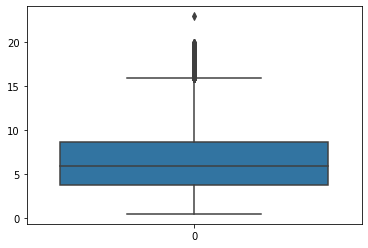

unit_sales(in millions)


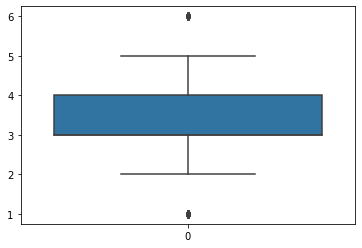

total_children


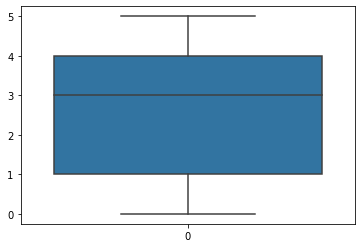

num_children_at_home


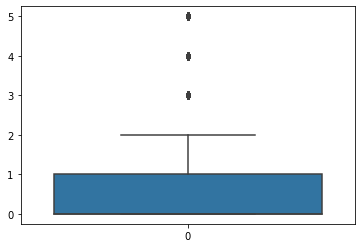

avg_cars_at home(approx).1


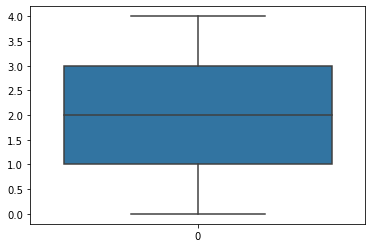

gross_weight


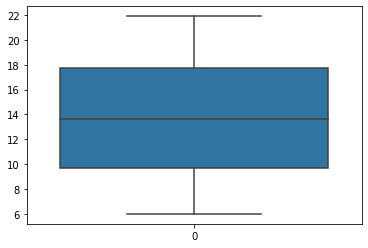

recyclable_package


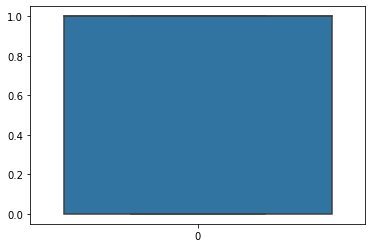

low_fat


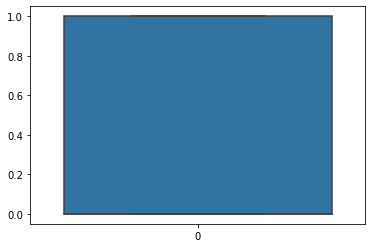

units_per_case


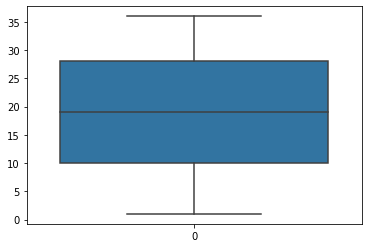

store_sqft


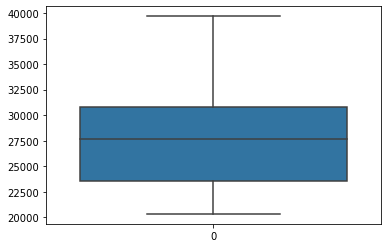

coffee_bar


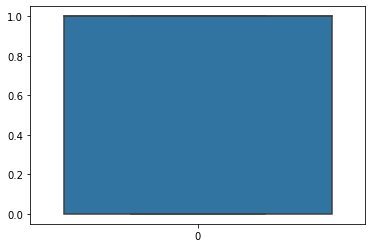

video_store


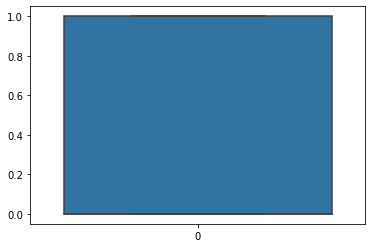

salad_bar


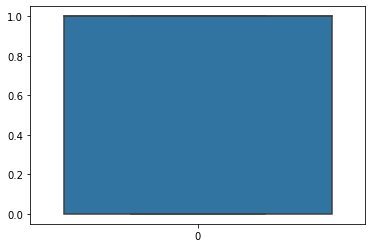

florist


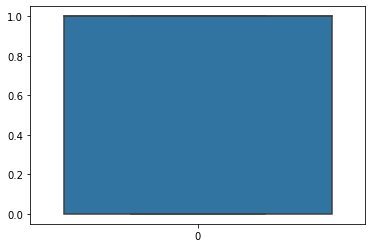

cost


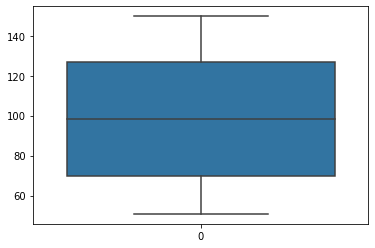

store_sale_by_weight


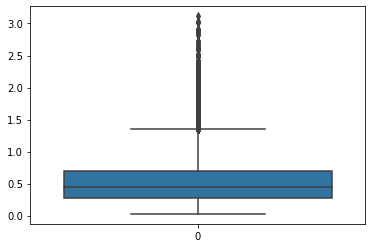

unit_sale_by_weight


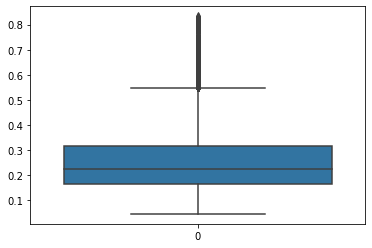

store_sale_by_case


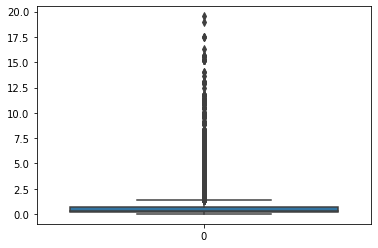

unit_sale_by_case


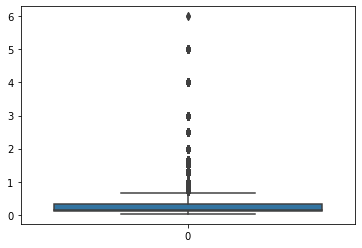

store_sale_by_sqft


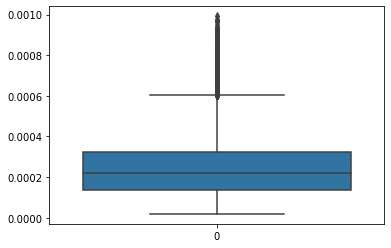

unit_sale_by_sqft


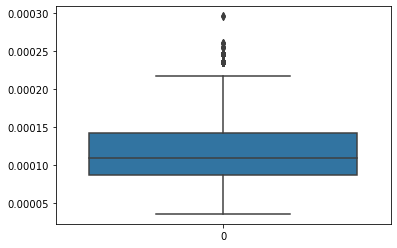

In [34]:
for i in train_df.columns:
    print(i)
    sns.boxplot(data=train_df[i])
    plt.show()